# Predict Future Sales

In [1]:
# maybe i wanna parse cities and shops locations (like 'ТРЦ')
# check item price distribution (i think i should normilize it)
# 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
train_data = pd.read_csv('./Data/sales_train.csv')
test_data = pd.read_csv('./Data/test.csv')
items_data = pd.read_csv('./Data/items.csv')
item_categories_data = pd.read_csv('./Data/item_categories.csv')
shops_data = pd.read_csv('./Data/shops.csv')

In [4]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
items_data.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_categories_data.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
item_categories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [10]:
item_categories_data

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [11]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
train_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [13]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [14]:
train_data.groupby(['date_block_num', 'item_id']).aggregate(np.sum)['item_cnt_day']

date_block_num  item_id
0               19           1.0
                27           7.0
                28           8.0
                29           4.0
                32         299.0
                           ...  
33              22162       10.0
                22163       26.0
                22164       15.0
                22166       11.0
                22167       37.0
Name: item_cnt_day, Length: 233912, dtype: float64

In [15]:
train_data = train_data.join(train_data.groupby(['date_block_num', 'item_id']).aggregate(np.sum)['item_cnt_day'], on=['date_block_num', 'item_id'], rsuffix='_right')

In [16]:
train_data.rename(columns={'item_cnt_day_right': 'item_cnt_month'}, inplace=True)

train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month
0,02.01.2013,0,59,22154,999.00,1.0,18.0
1,03.01.2013,0,25,2552,899.00,1.0,0.0
2,05.01.2013,0,25,2552,899.00,-1.0,0.0
3,06.01.2013,0,25,2554,1709.05,1.0,1.0
4,15.01.2013,0,25,2555,1099.00,1.0,2.0


In [17]:
train_data['date'] = train_data['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

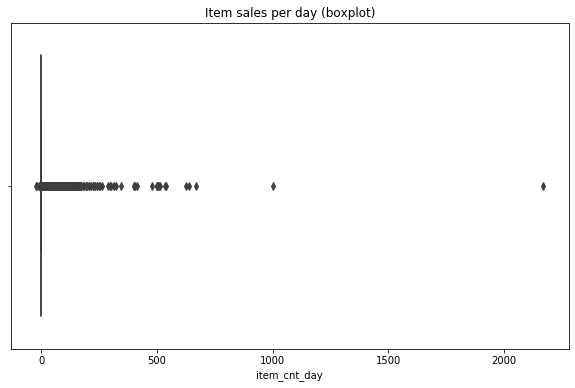

In [18]:
plt.figure(figsize=(10, 6))

plt.title('Item sales per day (boxplot)')
sns.boxplot(x='item_cnt_day', data=train_data)

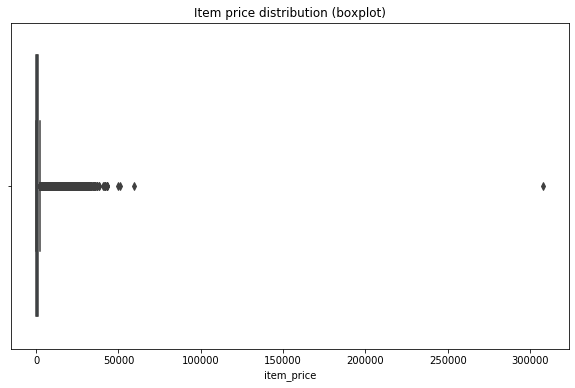

In [19]:
plt.figure(figsize=(10, 6))

plt.title('Item price distribution (boxplot)')
sns.boxplot(x='item_price', data=train_data)

In [20]:
train_data = train_data.loc[train_data['item_cnt_day'] < 1001]
train_data = train_data.loc[train_data['item_price'] < 50000]

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935845 entries, 0 to 2935848
Data columns (total 7 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
item_cnt_month    float64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 179.2 MB


In [25]:
print('Count of items in train set: ', len(train_data['item_id'].unique()))
print('Count of items in test set: ', len(train_data['item_id'].unique()))

Count of items in train set:  21805
Count of items in test set:  21805
